In [1]:
import os, sys
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

sys.path.append('..')
from script.utils import *
from Class.PlotConfig import *
from Class.Plotter import *

figPath = '../results/'

In [2]:
first_date = to_datetime('2020-02-29')
last_date = to_datetime('2022-05-17')
# first_date = to_datetime('03-01-2020')
# last_date = to_datetime('12-27-2022')
# last_date = to_datetime('12-29-2021')

In [3]:
print('Loading original')
target = 'Cases'
df_raw = pd.read_csv(f'../../dataset_raw/CovidMay17-2022/{target}.csv')
df_raw.head(3)

Loading original


,FIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2

In [4]:
df_raw = convert_cumulative_to_daily(df_raw)
id_vars = [col for col in df_raw.columns if not valid_date(col)]
df_raw = df_raw.melt(
    id_vars= id_vars,
    var_name='Date', value_name=target
).reset_index(drop=True)

# convert from string to datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# filter out dates not used in the study
df_raw = df_raw[
    (first_date <= df_raw['Date']) & 
    (df_raw['Date']<= last_date)
]
df_raw.head(3)

In [16]:
print('Loading cleaned')
df = pd.read_csv('../2022_May_cleaned/Total.csv')
df = df[['FIPS', 'Date', target]]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]

Loading cleaned


In [7]:
# original = df.describe().reset_index()
# print(original)
# cleaned = df.describe().reset_index()
# print(cleaned)

# original = original.round(3)
# cleaned = cleaned.round(3)

# stats = ['mean', 'std']
# for feature in cleaned.columns:
#     # ignore index and calculated features
#     if feature in ['index', 'FIPS', 'LinearSpace', 'SinWeekly', 'CosWeekly', 'TimeFromStart']: continue

#     line = feature
#     for stat in stats:
#         value = original[original['index']==stat][feature].values[0]
#         line += f' & {value}'

#     for stat in stats:
#         value = cleaned[cleaned['index']==stat][feature].values[0]
#         line += f' & {value}'
#     line += ' \\\\'
#     print(line)

AgeDist & 0.576 & 0.094 & 0.576 & 0.094 \\
HealthDisp & 0.368 & 0.198 & 0.368 & 0.198 \\
DiseaseSpread & 0.15 & 0.194 & 0.15 & 0.193 \\
Transmission & 0.492 & 0.21 & 0.491 & 0.21 \\
VaccinationFull & 20.609 & 22.922 & 20.609 & 22.923 \\
SocialDist & 0.784 & 0.228 & 0.795 & 0.229 \\
Cases & 31.667 & 337.405 & 27.183 & 174.15 \\
Deaths & 0.378 & 2.853 & 0.239 & 2.244 \\


In [17]:
total_raw = df_raw.groupby(['Date'])[target].aggregate('sum').reset_index()
total_cleaned = df.groupby(['Date'])[target].aggregate('sum').reset_index()

In [ ]:
target_df = total_cleaned
target_df.head()

In [22]:
def plot(df, target, scale:int=1e3, x_major_ticks:int=DATE_TICKS, figure_name:str=None):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x_column = 'Date'

    plt.plot(df[x_column], df[target])
    plt.ylim(bottom=0)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    # plt.xticks(rotation = 15)
        
    if scale>1:
        if scale==1e3 or scale==1e6:
            label_text = [] 
            if scale ==1e3: unit = 'K'
            else: unit = 'M'

            for loc in plt.yticks()[0]:
                if loc == 0:
                    label_text.append('0')
                else:
                    label_text.append(f'{loc/scale:0.5g}{unit}') 

            ax.set_yticklabels(label_text)
            plt.ylabel(f'Daily {target}')
        else:
            ax.yaxis.set_major_formatter(get_formatter(scale))
            if scale==1e3: unit = 'in thousands'
            elif scale==1e6: unit = 'in millions'
            else: unit = f'x {scale:.0e}'

            plt.ylabel(f'Daily {target} ({unit})')
    else:
        plt.ylabel(f'Daily {target}')

    # fig.tight_layout() # might change y axis values

    # if figure_name is not None:
    #     plt.savefig(os.path.join(figPath, figure_name), dpi=DPI)
    plt.show()

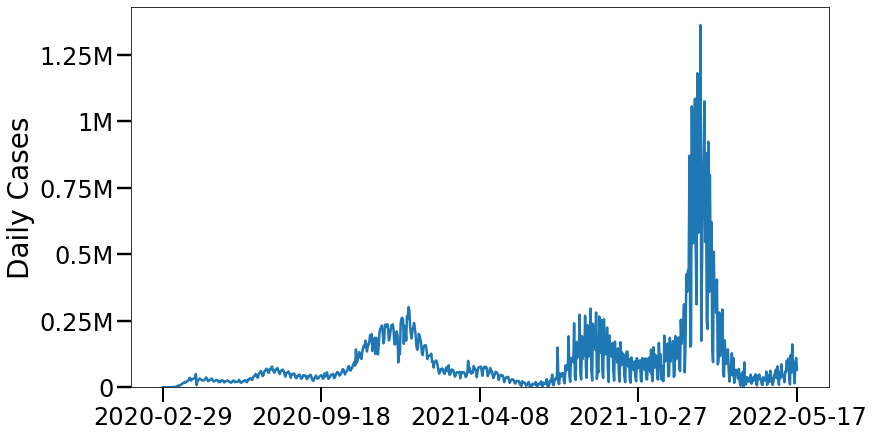

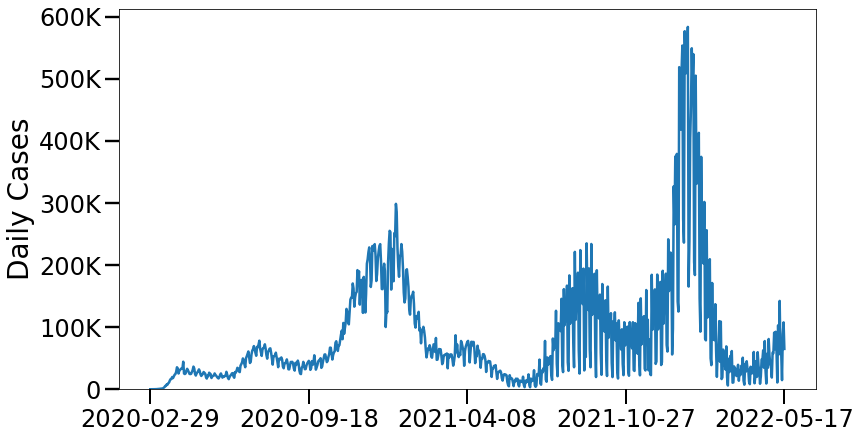

In [23]:
plot(total_raw, target, figure_name=f'{target}_original.jpg', scale=1e6)
plot(total_cleaned, target, figure_name=f'{target}_cleaned_iqr_7.5.jpg')

In [ ]:
# fig, ax = plt.subplots(figsize=FIGSIZE)

# for target in targets:
#     plt.plot(total_raw['Date'], total_raw[target], label=target)

# x_first_tick = total_raw['Date'].min()
# x_last_tick = total_raw['Date'].max()
# x_major_ticks = DATE_TICKS
# ax.set_xticks(
#     [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
# )
# plt.xticks(rotation = 15)
# plt.yscale('log')
# plt.ylabel(f'Daily count (log scaled)')

# plt.legend()
# # fig.tight_layout() # might change y axis values
# plt.savefig(os.path.join(figPath, 'Combined-log-scaled.jpg'), dpi=DPI)
# plt.show()

In [83]:
splits =  {
    # 'Primary': [to_datetime('2021-11-29'), (-25, 120)],
    'Rising 3rd \nWave': [to_datetime('2021-12-31'), (-60, 120)],
    'Falling \n3rd Wave': [to_datetime('2022-01-31'), (49, 200)],
    'Post 3rd \nWave': [to_datetime('2022-02-28'), (40, 100)]
}

In [25]:
target  ='Cases'
scale=1e6
x_major_ticks=DATE_TICKS
x_column = 'Date'

dates = total_cleaned[x_column].values

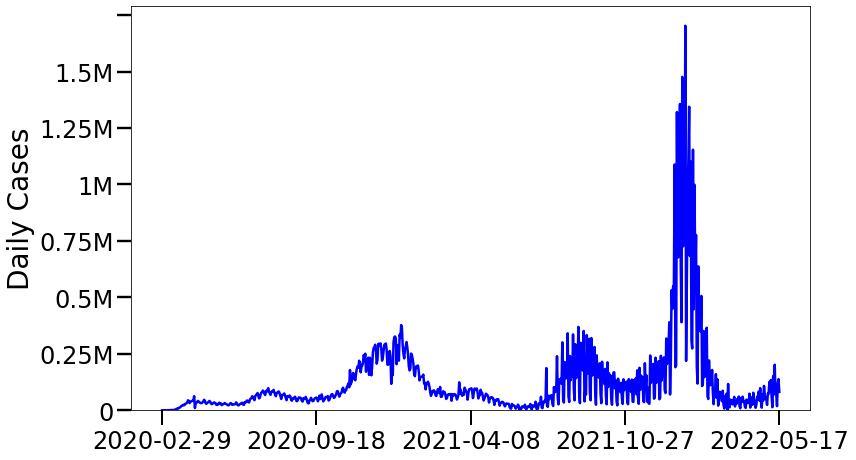

In [86]:
fig, ax = plt.subplots(figsize=(12, 6.5))
plt.plot(dates, total_raw[target], color='blue', label='Raw')
plt.plot(dates, total_cleaned[target], color='blue', label='Outlier Removed', alpha=0.7)
plt.ylim(bottom=0)

x_first_tick = dates.min()
x_last_tick = dates.max()
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
# plt.xticks(rotation = 15)

arrowprops = dict(arrowstyle="simple, head_length=0.5, head_width=0.3, tail_width=0.1")
# splits =  {
#     # 'Primary': [to_datetime('2021-11-29'), (0, 120)],
#     'Rising 3rd Wave': [to_datetime('2021-12-31'), (0, 150)],
#     'Falling 3rd Wave': [to_datetime('2022-01-31'), (0, 150)],
#     'Post 3rd Wave': [to_datetime('2022-02-28'), (0, 120)]
# }
for index, split in enumerate(splits):
    x = splits[split][0]
    y = total_cleaned[total_cleaned[x_column]==x][target].values[0]
    ax.annotate(split, # split, # manually add the text for better visibility
        xy=(x, y),
        xytext=splits[split][1], 
        textcoords='offset points',
        size=25, 
        va="center",ha='center',
        arrowprops=dict(arrowstyle="->", color='orange',lw=4, connectionstyle="arc3"),
        color='black'
    )

if scale>1:
    if scale==1e3 or scale==1e6:
        label_text = [] 
        if scale ==1e3: unit = 'K'
        else: unit = 'M'

        for loc in plt.yticks()[0]:
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/scale:0.5g}{unit}') 

        ax.set_yticklabels(label_text)
        plt.ylabel(f'Daily {target}')
    else:
        ax.yaxis.set_major_formatter(get_formatter(scale))
        if scale==1e3: unit = 'in thousands'
        elif scale==1e6: unit = 'in millions'
        else: unit = f'x {scale:.0e}'

        plt.ylabel(f'Daily {target} ({unit})')
else:
    plt.ylabel(f'Daily {target}')

fig.tight_layout() # might change y axis values
plt.legend(loc='upper left')

plt.savefig(os.path.join(figPath, 'ground_truth_extra_splits.jpg'), dpi=DPI)
plt.show()